In [62]:
# Note need r5.4xl to run this on
import os
import sys
import time
import random
import warnings
import collections
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, HalvingRandomSearchCV 
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, StackingRegressor, HistGradientBoostingRegressor 

# from sklearn.linear_model import Ridge, Lasso, BayesianRidge, ElasticNet
from sklearn.preprocessing import OneHotEncoder

sys.path.append('../../src')
%pip install pymysql
import cb_utils
import cb_model_utils

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

import sagemaker
from sagemaker.sklearn.estimator import SKLearn

%load_ext autoreload
%autoreload 2

The scikit-learn version is 1.1.3.
Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# configuration
use_cache = False
seed = random.randint(0, 100)

print(f'Seed: {seed}')

Seed: 20


In [3]:
query = f"select * from fn_dsml_sfere_features_v2_fl();"
fl_features = cb_utils.sql_query_to_df(query, use_cache=use_cache, source='member_doc')

Pulling query from db


In [4]:
fl_features.head()

,sfere_id,patient_id,sfere_type_ft,payer_id_ft,group_id_ft,age_ft,transfer_bed_to_chair_ft,mobility_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,turn_change_position_ft,has_incontinence_ft,incontinence_type_ft,incontinence_frequency_ft,bathing_support_days_natural_ft,dressing_support_days_natural_ft,eating_support_days_natural_ft,grooming_support_days_natural_ft,toileting_support_days_natural_ft,mobility_support_days_natural_ft,transfer_bed_to_chair_support_days_natural_ft,turn_change_position_support_days_natural_ft,bathing_transfers_support_days_natural_ft,dressing_lower_support_days_natural_ft,hair_support_days_natural_ft,mobility_outside_support_days_natural_ft,calling_friends_and_family_ft,articulating_needs_ft,meal_prep_ft,shopping_ft,medication_management_ft,finances_ft,housework_ft,transportation_ft,daily_routine_decisions_ft,comprehension_ft,member_opinion_ft,cleaning_ft,laundry_ft,change_bed_ft,clean_kitchen_ft,clean_home_ft,medical_appointments_ft,work_school_socialize_ft,driving_ft,calling_friends_and_family_support_days_natural_ft,finances_support_days_natural_ft,laundry_support_days_natural_ft,housework_support_days_natural_ft,meal_prep_support_days_natural_ft,medication_management_support_days_natural_ft,shopping_support_days_natural_ft,alert_oriented_self_ft,alert_oriented_place_ft,alert_oriented_day_time_ft,has_alz_or_dem_ft,has_acquired_cognitive_deficit_ft,has_developmental_delay_ft,has_idd_ft,has_no_cog_deficit_ft,has_traumatic_brain_injury_ft,on_ventilator_ft,using_oxygen_ft,has_paralysis_ft,has_amputations_ft,receive_wound_care_ft,has_ostomy_ft,receiving_enteral_feedings_ft,using_specialized_bed_ft,using_mobility_device_ft,has_dme_ft,mean_supports_ft,reporting_current_hrs_ft,reporting_rec_hrs_tg
0,8590,2113,1,4,2,33.0,3,3,3,3,3,3.0,3,None,1,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,1,1.0,1,1,1,1,1,1,NaN,NaN,NaN,None,NaN,None,None,None,None,None,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0,0.0,1.0,1.0,1.0,1.0,0.0,NaN,14.0,14.0
1,55517,2113,1,4,2,33.0,3,3,3,3,3,3.0,3,None,1,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,0,0.0,1,0,0,0,0,0,0.0,1.0,1.0,None,NaN,None,None,None,None,None,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,14.0,14.0
2,6376,2115,1,4,2,69.0,3,0,3,3,3,3.0,3,None,1,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,0,0.0,0,0,0,0,0,0,NaN,NaN,NaN,None,NaN,None,None,None,None,None,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0,1.0,0.0,0.0,1.0,1.0,1.0,NaN,20.0,20.0
3,6380,2115,1,4,2,69.0,3,0,3,3,3,3.0,3,None,1,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,0,0.0,0,0,0,0,0,0,NaN,NaN,NaN,None,NaN,None,None,None,None,None,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0,1.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,20.0
4,76130,2115,2,4,2,69.0,3,0,3,3,3,3.0,3,None,1,2.0,2.0,2.0,2.0,7.0,7.0,7.0,NaN,NaN,None,None,None,None,None,3,NaN,3,3,3,3,3,3,NaN,NaN,NaN,None,3.0,None,None,None,None,None,NaN,7.0,7.0,7.0,2.0,7.0,7.0,7.0,1.0,1.0,1.0,NaN,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,0,1.0,NaN,NaN,NaN,NaN,NaN,5.75,20.0,20.0


In [7]:
# exclude missing target
fl_features = fl_features.loc[~fl_features.reporting_rec_hrs_tg.isna()]

In [8]:
final_columns = [
 'reporting_rec_hrs_tg',
 'transfer_bed_to_chair_ft',
 'mobility_ft',
 'dressing_ft',
 'bathing_ft',
 'eating_ft',
 'grooming_ft',
 'toileting_ft',
 'has_incontinence_ft',
 'incontinence_type_ft',
 'incontinence_frequency_ft',
 'calling_friends_and_family_ft',
 'articulating_needs_ft',
 'meal_prep_ft',
 'shopping_ft',
 'medication_management_ft',
 'finances_ft',
 'housework_ft',
 'transportation_ft',
 'daily_routine_decisions_ft',
 'comprehension_ft',
 'member_opinion_ft',
 'laundry_ft',
 'driving_ft',
 'on_ventilator_ft',
 'using_oxygen_ft',
 'has_paralysis_ft',
 'has_amputations_ft',
 'receive_wound_care_ft',
 'has_ostomy_ft',
 'receiving_enteral_feedings_ft',
 'using_specialized_bed_ft',
 'using_mobility_device_ft',
 'has_dme_ft',
 'sfere_type_ft',
 'payer_id_ft',
 'mean_supports_ft',
 'age_ft',
 'reporting_current_hrs_ft'
]

### Test training on file

In [11]:
df = fl_features
# df.columns = final_columns
df.head()

,sfere_id,patient_id,sfere_type_ft,payer_id_ft,group_id_ft,age_ft,transfer_bed_to_chair_ft,mobility_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,turn_change_position_ft,has_incontinence_ft,incontinence_type_ft,incontinence_frequency_ft,bathing_support_days_natural_ft,dressing_support_days_natural_ft,eating_support_days_natural_ft,grooming_support_days_natural_ft,toileting_support_days_natural_ft,mobility_support_days_natural_ft,transfer_bed_to_chair_support_days_natural_ft,turn_change_position_support_days_natural_ft,bathing_transfers_support_days_natural_ft,dressing_lower_support_days_natural_ft,hair_support_days_natural_ft,mobility_outside_support_days_natural_ft,calling_friends_and_family_ft,articulating_needs_ft,meal_prep_ft,shopping_ft,medication_management_ft,finances_ft,housework_ft,transportation_ft,daily_routine_decisions_ft,comprehension_ft,member_opinion_ft,cleaning_ft,laundry_ft,change_bed_ft,clean_kitchen_ft,clean_home_ft,medical_appointments_ft,work_school_socialize_ft,driving_ft,calling_friends_and_family_support_days_natural_ft,finances_support_days_natural_ft,laundry_support_days_natural_ft,housework_support_days_natural_ft,meal_prep_support_days_natural_ft,medication_management_support_days_natural_ft,shopping_support_days_natural_ft,alert_oriented_self_ft,alert_oriented_place_ft,alert_oriented_day_time_ft,has_alz_or_dem_ft,has_acquired_cognitive_deficit_ft,has_developmental_delay_ft,has_idd_ft,has_no_cog_deficit_ft,has_traumatic_brain_injury_ft,on_ventilator_ft,using_oxygen_ft,has_paralysis_ft,has_amputations_ft,receive_wound_care_ft,has_ostomy_ft,receiving_enteral_feedings_ft,using_specialized_bed_ft,using_mobility_device_ft,has_dme_ft,mean_supports_ft,reporting_current_hrs_ft,reporting_rec_hrs_tg
0,8590,2113,1,4,2,33.0,3,3,3,3,3,3.0,3,None,1,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,1,1.0,1,1,1,1,1,1,NaN,NaN,NaN,None,NaN,None,None,None,None,None,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0,0.0,1.0,1.0,1.0,1.0,0.0,NaN,14.0,14.0
1,55517,2113,1,4,2,33.0,3,3,3,3,3,3.0,3,None,1,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,0,0.0,1,0,0,0,0,0,0.0,1.0,1.0,None,NaN,None,None,None,None,None,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,14.0,14.0
2,6376,2115,1,4,2,69.0,3,0,3,3,3,3.0,3,None,1,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,0,0.0,0,0,0,0,0,0,NaN,NaN,NaN,None,NaN,None,None,None,None,None,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0,1.0,0.0,0.0,1.0,1.0,1.0,NaN,20.0,20.0
3,6380,2115,1,4,2,69.0,3,0,3,3,3,3.0,3,None,1,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,0,0.0,0,0,0,0,0,0,NaN,NaN,NaN,None,NaN,None,None,None,None,None,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0,1.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,20.0
4,76130,2115,2,4,2,69.0,3,0,3,3,3,3.0,3,None,1,2.0,2.0,2.0,2.0,7.0,7.0,7.0,NaN,NaN,None,None,None,None,None,3,NaN,3,3,3,3,3,3,NaN,NaN,NaN,None,3.0,None,None,None,None,None,NaN,7.0,7.0,7.0,2.0,7.0,7.0,7.0,1.0,1.0,1.0,NaN,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,0,1.0,NaN,NaN,NaN,NaN,NaN,5.75,20.0,20.0


In [12]:
test_pct = 0.1

patient_ids = df.patient_id.unique().tolist()
test_df_patient_ids = random.sample(patient_ids, int(df.shape[0]*test_pct))

test_df = df.loc[df.patient_id.isin(test_df_patient_ids)]
training_df = df.loc[~df.patient_id.isin(test_df_patient_ids)]

print(f'{test_df.shape[0]} test samples, for {len(test_df_patient_ids)} unique patients')
print(f'{training_df.shape[0]} training samples, for {training_df.patient_id.unique().shape[0]} unique patients')

1043 test samples, for 796 unique patients
6921 training samples, for 5225 unique patients


In [14]:
features = final_columns[1:]
target = final_columns[0]
categorical_feature_indexes = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]

In [17]:
x_train = training_df[features]
y_train = training_df[target]
x_test = test_df[features]
y_test = test_df[target]

est = HistGradientBoostingRegressor(categorical_features=categorical_feature_indexes,
                                       max_iter=1000).fit(x_train, y_train)

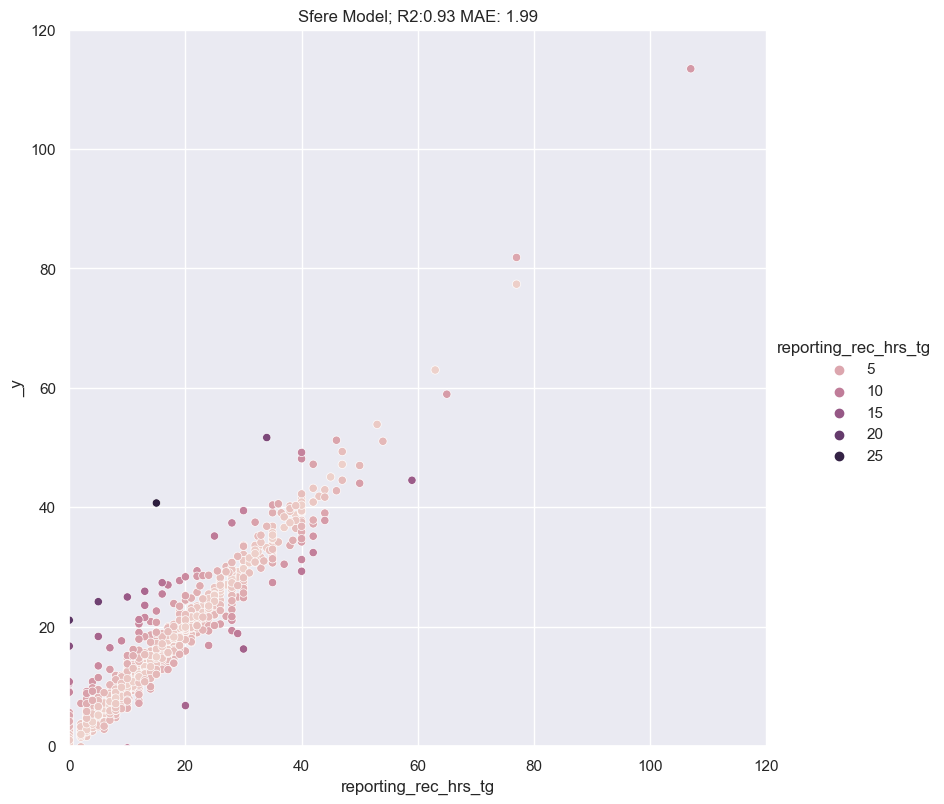

In [18]:
preds = est.predict(x_test)

# preds vs rec
ax = sns.relplot(x=y_test, y=preds, height=8, hue=np.abs(y_test - preds))
ax.set(ylim=(0, 120))
ax.set(xlim=(0, 120))
ax.set(title=f'Sfere Model; R2:{est.score(x_test, y_test):.02f} MAE: {np.mean(np.abs(y_test - preds)):.02f}');
plt.show()


In [63]:
print(f'Feature importances on training')
r = permutation_importance(est, x_train, y_train,
                           n_jobs=-1,
                           n_repeats=50,
                           random_state=0)

best_features = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        best_features.append(features[i])
        print(f"{features[i]:<8} "
              f"{r.importances_mean[i]:.3f} "
              f" +/- {r.importances_std[i]:.3f}")

Feature importances on training
reporting_current_hrs_ft 1.507  +/- 0.020
age_ft   0.017  +/- 0.000
receiving_enteral_feedings_ft 0.012  +/- 0.001
toileting_ft 0.011  +/- 0.000
bathing_ft 0.009  +/- 0.000
eating_ft 0.008  +/- 0.000
housework_ft 0.008  +/- 0.000
dressing_ft 0.007  +/- 0.000
grooming_ft 0.006  +/- 0.000
meal_prep_ft 0.005  +/- 0.000
mobility_ft 0.004  +/- 0.000
medication_management_ft 0.004  +/- 0.000
transfer_bed_to_chair_ft 0.004  +/- 0.000
shopping_ft 0.004  +/- 0.000
mean_supports_ft 0.004  +/- 0.000
incontinence_frequency_ft 0.004  +/- 0.000
member_opinion_ft 0.003  +/- 0.000
receive_wound_care_ft 0.003  +/- 0.000
incontinence_type_ft 0.002  +/- 0.000
calling_friends_and_family_ft 0.002  +/- 0.000
transportation_ft 0.002  +/- 0.000
payer_id_ft 0.002  +/- 0.000
finances_ft 0.002  +/- 0.000
using_mobility_device_ft 0.001  +/- 0.000
using_specialized_bed_ft 0.001  +/- 0.000
has_dme_ft 0.001  +/- 0.000
articulating_needs_ft 0.001  +/- 0.000
daily_routine_decisions_ft 0

In [64]:
print(f'Feature importances on test')
r = permutation_importance(est, x_test, y_test,
                           n_jobs=-1,
                           n_repeats=50,
                           random_state=0)

best_features = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        best_features.append(features[i])
        print(f"{features[i]:<8} "
              f"{r.importances_mean[i]:.3f} "
              f" +/- {r.importances_std[i]:.3f}")

Feature importances on test
reporting_current_hrs_ft 1.472  +/- 0.052
toileting_ft 0.009  +/- 0.002
bathing_ft 0.007  +/- 0.001
housework_ft 0.004  +/- 0.001
mean_supports_ft 0.003  +/- 0.001
dressing_ft 0.003  +/- 0.001
meal_prep_ft 0.002  +/- 0.001
shopping_ft 0.002  +/- 0.001
driving_ft 0.001  +/- 0.000


In [65]:
common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

Computing partial dependence plots...
done in 21.350s


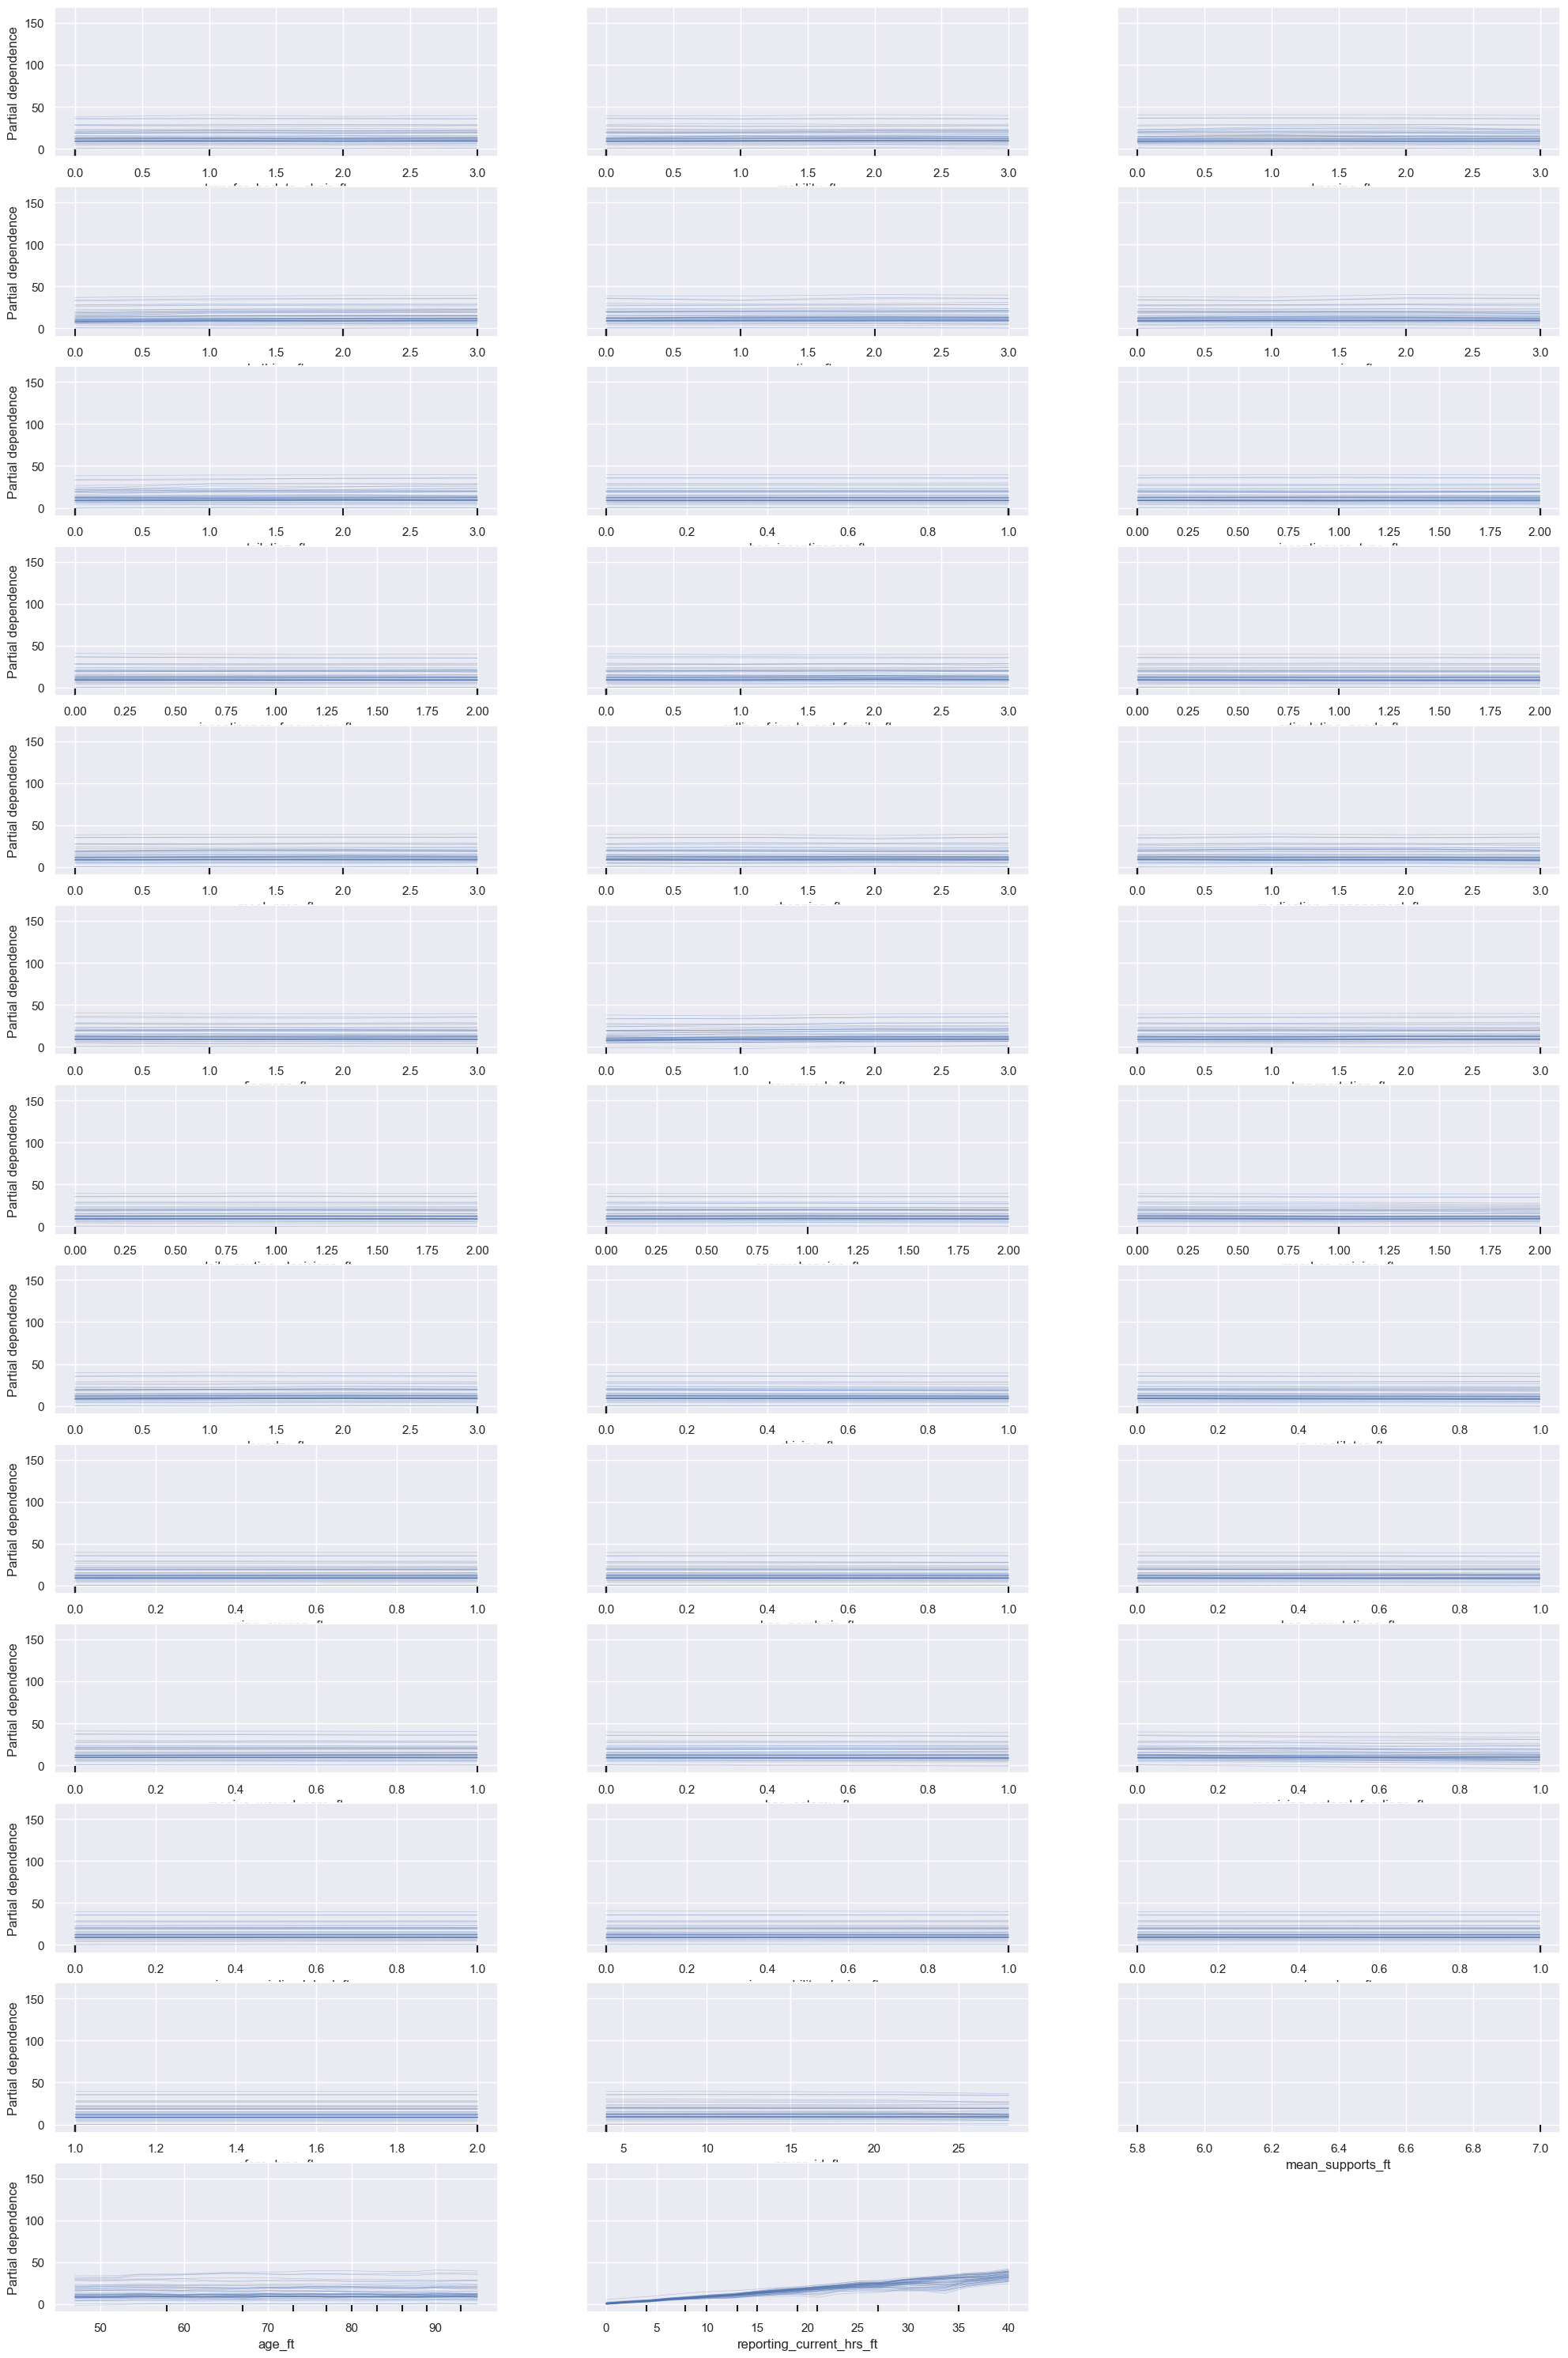

In [60]:
from time import time
from sklearn.inspection import PartialDependenceDisplay


print("Computing partial dependence plots...")
tic = time()

n_features = 38
display = PartialDependenceDisplay.from_estimator(
    est,
    x_train,
    features=[i for i in range(n_features)],
    feature_names=[x_train.columns[i] for i in range(n_features)], 
    kind='individual',
    **common_params,
)

print(f"done in {time() - tic:.3f}s")
display.figure_.set_figwidth(20)
display.figure_.set_figheight(30)
display.figure_.tight_layout()